In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader,ConcatDataset
import torchvision
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from tqdm import tqdm
import torch.nn.functional as F
from torchvision import utils as vutils
from torchvision.transforms import Compose, RandomAdjustSharpness,RandomAutocontrast, RandomEqualize, ColorJitter
import os 

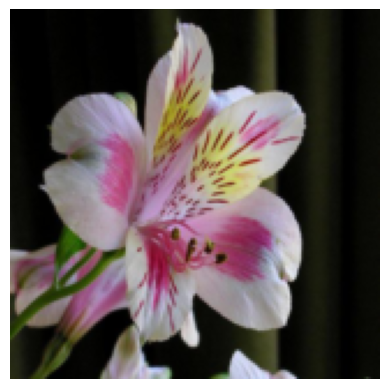

In [2]:
n_c=3  # number of channels in the image (RGB)
batch_size=6 # batch size for training
transform=transforms.Compose(transforms=[
                                         transforms.ToTensor(),
                                            transforms.Resize((160,160)),
transforms.Normalize([0.5 for _ in range(n_c)],[0.5 for _ in range(n_c)])])


# dataset=datasets.ImageFolder(root='C:/Users/shree/OneDrive/Documents/VQGAN/scenes',transform=transform)
# data_loader=DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)

train_ds = datasets.Flowers102(
    root='data',           # where to download/store
    split='train',         # one of 'train', 'test', 'val'
    download=True,         # download if not present
    transform=transform    # apply your preprocessing
)

test_ds = datasets.Flowers102(
    root='data',           # where to download/store
    split='test',         # one of 'train', 'test', 'val'
    download=True,         # download if not present
    transform=transform    # apply your preprocessing
)

val_ds = datasets.Flowers102(
    root='data',           # where to download/store
    split='val',         # one of 'train', 'test', 'val'
    download=True,         # download if not present
    transform=transform    # apply your preprocessing
)

dataset = ConcatDataset([train_ds, test_ds])

data_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_data_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)



image=next(iter(data_loader))

import matplotlib.pyplot as plt
plt.imshow((image[0][0]*0.5+0.5).permute(1,2,0))
plt.axis("off")
plt.show()


In [3]:
class GroupNorm(nn.Module):
    def __init__(self, channels):
        super(GroupNorm, self).__init__()
        self.group_norm=nn.GroupNorm(num_groups=32, num_channels=channels, eps=1e-6, affine=True)

    def forward(self, x):
        return self.group_norm(x)
    

class swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
    

class ResidualBlock(nn.Module):
    def __init__(self, in_channels,out_channels):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.block= nn.Sequential(
            GroupNorm(self.in_channels),
            swish(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1,padding=1),
            GroupNorm(out_channels),
            swish(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3,stride=1, padding=1),
        )

    #  if  the no. of out channels and in channels are not equal, we need to add a conv layer to match the dimensions
        if in_channels != out_channels:
            self.match_dimensions = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        if self.in_channels != self.out_channels:
            return self.match_dimensions(x)+self.block(x)
        
        else:
            return x + self.block(x)
        

class UpsampleBlock(nn.Module):
    def __init__(self, channels):
        super(UpsampleBlock, self).__init__()
        self.conv= nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x=F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)
    
class DownsampleBlock(nn.Module):
    def __init__(self, channels):
        super(DownsampleBlock, self).__init__()
        self.conv= nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=0)

    def forward(self, x):
        pad = (0, 1, 0, 1)
        x = F.pad(x, pad, mode="constant", value=0)
        return self.conv(x)
    

class NonLocalBlock(nn.Module):
    def __init__(self, channels):
        super(NonLocalBlock, self).__init__()
        self.gn= GroupNorm(channels)

        self.q= nn.Conv2d(channels, channels, kernel_size=1, stride=1, padding=0)
        self.k= nn.Conv2d(channels, channels, kernel_size=1, stride=1, padding=0)
        self.v= nn.Conv2d(channels, channels, kernel_size=1, stride=1, padding=0)

        self.project= nn.Conv2d(channels, channels, kernel_size=1, stride=1, padding=0)
       

    def forward(self, x):

        norm= self.gn(x)
        q= self.q(norm)
        k=self.k(norm)
        v=self.v(norm)
        b, c, h, w = q.shape
        q = q.view(b, c, -1)
        k = k.view(b, c, -1).permute(0, 2, 1)
        v = v.view(b, c, -1)
        # Calculate attention scores
        attn_scores = (q @ k)/ (c ** 0.5)
        attn_scores = F.softmax(attn_scores, dim=-1)
        attn_output = attn_scores @ v
        attn_output = attn_output.view(b, c, h, w)

        A= self.project(attn_output)
        
       
        return x+A

In [4]:
class Encoder(nn.Module):
    def __init__(self, in_channels,latent_dim):
        super(Encoder, self).__init__()
        channels = [128, 128, 128, 256, 256, 512]
        attn_resolution=[16]
        m=2
        resolution=256

        layers = [nn.Conv2d(in_channels, channels[0], kernel_size=3, stride=1, padding=1),]
        for i in range(len(channels)-1):
            input_channels = channels[i]
            output_channels = channels[i+1]
            for j in range(m):
                layers.append(ResidualBlock(input_channels, output_channels))
                input_channels = output_channels

                if resolution in attn_resolution:
                    layers.append(NonLocalBlock(input_channels))

            if i != len(channels)-2:
                layers.append(DownsampleBlock(channels[i+1]))
                resolution = resolution // 2

        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(NonLocalBlock(channels[-1]))
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(GroupNorm(channels[-1]))
        layers.append(swish())  
        layers.append(nn.Conv2d(channels[-1], latent_dim, kernel_size=3, stride=1, padding=1))
        self.model=nn.Sequential(*layers)


        

    def forward(self, x):
    
        return self.model(x)
    


class Decoder(nn.Module):
    def __init__(self, latent_dim,out_channels):
        super(Decoder, self).__init__()
        channels = [512, 256, 256, 128, 128]
        attn_resolution=[16]
        resolution=16
        m=3
        self.image_channels=out_channels
        in_channels = channels[0]

        layers = [nn.Conv2d(latent_dim,in_channels, kernel_size=3, stride=1, padding=1),
                  ResidualBlock(in_channels, in_channels),
                  NonLocalBlock(in_channels),   
                  ResidualBlock(in_channels, in_channels),]
        
        for i in range(len(channels)):
            out_channels = channels[i]
            for j in range(m):
                layers.append(ResidualBlock(in_channels,out_channels))
                in_channels = out_channels
                
                if resolution in attn_resolution:
                    layers.append(NonLocalBlock(in_channels))
                    
            if i !=0:
                layers.append(UpsampleBlock(in_channels))
                resolution = resolution * 2

        layers.append(GroupNorm(in_channels))
        layers.append(swish())  
        layers.append(nn.Conv2d(in_channels, self.image_channels, kernel_size=3, stride=1, padding=1))
        self.model=nn.Sequential(*layers)


    def forward(self, x):
    
        return self.model(x)
    

class Codebook(nn.Module):
    def __init__(self, k,latent_dim,beta):
        super(Codebook, self).__init__()
        self.k= k
        self.embedding_dim = latent_dim
        self.beta= beta
        self.embeded_space= nn.Embedding(self.k, self.embedding_dim)
        self.embeded_space.weight.data.uniform_(-1/self.k, 1/self.k)

    def forward(self, z):
        z =z.permute(0, 2, 3, 1).contiguous()  # Change to (batch_size, height, width, channels)
        z_flattened = z.view(-1, self.embedding_dim)
        # l2_norm expanded into a2+b2-2ab as z is (4096, 64) and embeded_space.weight is (512, 64) thus on exapnsion (4096, 1) and (1, 512) respectively thus can be added by bradcasting 
        l2_norm= torch.sum(z_flattened ** 2, dim=1, keepdim=True)+torch.sum(self.embeded_space.weight ** 2, dim=1) - 2 * torch.matmul(z_flattened, self.embeded_space.weight.t())
        min_indices = torch.argmin(l2_norm, dim=1)
        z_q= self.embeded_space(min_indices).view(z.shape)

        loss = self.beta*torch.mean((z.detach()   - z_q)**2) +  torch.mean((z - z_q.detach())**2)

        # preserve gradients
        z_q = z + (z_q - z).detach()
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return z_q, loss, min_indices
    



class VQGAN(nn.Module):
    def __init__(self,in_channels,latent_dim,k,out_channels,beta):
        super(VQGAN, self).__init__()
        self.encoder = Encoder(in_channels,latent_dim).to(device)
        self.decoder = Decoder(latent_dim,out_channels).to(device)
        self.codebook = Codebook(k,latent_dim,beta).to(device)
        self.pre_quant_conv = nn.Conv2d(latent_dim, latent_dim, kernel_size=1, stride=1, padding=0).to(device)
        self.post_quant_conv = nn.Conv2d(latent_dim, latent_dim, kernel_size=1, stride=1, padding=0).to(device)

    def encode(self, x):
        z_e=self.encoder(x)
        z_e=self.pre_quant_conv(z_e)
        z_q, loss, indices = self.codebook(z_e)
        return z_e, loss, indices   
    
    def decode(self, z_q):
        z_q = self.post_quant_conv(z_q)
        return self.decoder(z_q)
    

    def code_book(self, z_e):
        return self.codebook(z_e)
    

    def lambda_(self, perceptual_loss, gan_loss):
        last_layer=self.decoder.model[-1]
        last_layer_weight = last_layer.weight
        recon_loss_grads = torch.autograd.grad(perceptual_loss, last_layer_weight, retain_graph=True)[0]
        gan_loss_grads = torch.autograd.grad(gan_loss, last_layer_weight, retain_graph=True)[0]

        lambda_ = torch.norm(recon_loss_grads) / (torch.norm(gan_loss_grads) + 1e-6)
        lambda_ = torch.clamp(lambda_, 0, 1e4).detach()

        return 0.8*lambda_

    # def lambda_(self, recon_loss, gan_loss):
    #     # get the very last linear layer in your VQGAN generator
    #     last_layer = self.decoder.model[-1]  # or whatever your last layer is
    #     last_weight = last_layer.weight
    
    #     # compute recon grad
    #     recon_loss_grads = torch.autograd.grad(
    #         recon_loss,
    #         last_weight,
    #         retain_graph=True,
    #         allow_unused=True
    #     )[0]
    #     # compute gan grad
    #     gan_loss_grads = torch.autograd.grad(
    #         gan_loss,
    #         last_weight,
    #         retain_graph=True,
    #         allow_unused=True
    #     )[0]
    
    #     # replace None with zeros
    #     if recon_loss_grads is None:
    #         recon_loss_grads = torch.zeros_like(last_weight)
    #     if gan_loss_grads is None:
    #         gan_loss_grads = torch.zeros_like(last_weight)

    #     mean_gan_grad_abs = torch.mean(torch.abs(gan_loss_grads))

    #     if mean_gan_grad_abs<0.0001:
    #         lambda_val=0.1
    #         return lambda_val
            
    
        # # compute your ratio
        # lambda_val = torch.mean(torch.abs(recon_loss_grads)) \
        #            / (torch.mean(torch.abs(gan_loss_grads)) + 1e-6)
        # return torch.clamp(lambda_val, 0, 1e4).detach()*0.8

    

    @staticmethod
    def adapt_weights(disc_factor,i,threshold,value=0.2):

        """Starting the discrimator later in training, so that our model has enough time to generate "good-enough" images to try to "fool the discrimator".

        To do that, we before eaching a certain global step, set the discriminator factor by `value` ( default 0.0 ) .
        This discriminator factor is then used to multiply the discriminator's loss.

        Args:
            disc_factor (float): This value is multiple to the discriminator's loss.
            i (int): The current global step
            threshold (int): The global step after which the `disc_factor` value is retured.
            value (float, optional): The value of discriminator factor before the threshold is reached. Defaults to 0.0.

        Returns:
            float: The discriminator factor.
        """

        if i < threshold:
            disc_factor=value
        
        return disc_factor
        

    def forward(self, x):
        z_e = self.encoder(x)
        z_e = self.pre_quant_conv(z_e)
        z_q, loss, indices = self.codebook(z_e)
        z_q = self.post_quant_conv(z_q)
        x_recon = self.decoder(z_q)
        return x_recon, loss, indices
    

    def load_checkpoint(self, path):
        self.load_state_dict(torch.load(path))


    
class Discriminator(nn.Module):
    def __init__(self,in_channels):
        super().__init__()
        self.patch_gan=nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=1,padding=1,bias=False),
            # nn.BatchNorm2d(512),
            # nn.LeakyReLU(0.2,inplace=True),
            # nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=1,padding=1,bias=False)

        )

    def forward(self,x):
        return self.patch_gan(x)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
import os
import torch
import torch.nn as nn
from torchvision.models import vgg16
from collections import namedtuple
import requests
from tqdm import tqdm


URL_MAP = {
    "vgg_lpips": "https://heibox.uni-heidelberg.de/f/607503859c864bc1b30b/?dl=1"
}

CKPT_MAP = {
    "vgg_lpips": "vgg.pth"
}


def download(url, local_path, chunk_size=1024):
    os.makedirs(os.path.split(local_path)[0], exist_ok=True)
    with requests.get(url, stream=True) as r:
        total_size = int(r.headers.get("content-length", 0))
        with tqdm(total=total_size, unit="B", unit_scale=True) as pbar:
            with open(local_path, "wb") as f:
                for data in r.iter_content(chunk_size=chunk_size):
                    if data:
                        f.write(data)
                        pbar.update(chunk_size)


def get_ckpt_path(name, root):
    assert name in URL_MAP
    path = os.path.join(root, CKPT_MAP[name])
    if not os.path.exists(path):
        print(f"Downloading {name} model from {URL_MAP[name]} to {path}")
        download(URL_MAP[name], path)
    return path


class LPIPS(nn.Module):
    def __init__(self):
        super(LPIPS, self).__init__()
        self.scaling_layer = ScalingLayer()
        self.channels = [64, 128, 256, 512, 512]
        self.vgg = VGG16()
        self.lins = nn.ModuleList([
            NetLinLayer(self.channels[0]),
            NetLinLayer(self.channels[1]),
            NetLinLayer(self.channels[2]),
            NetLinLayer(self.channels[3]),
            NetLinLayer(self.channels[4])
        ])

        self.load_from_pretrained()

        for param in self.parameters():
            param.requires_grad = False

    def load_from_pretrained(self, name="vgg_lpips"):
        ckpt = get_ckpt_path(name, "vgg_lpips")
        self.load_state_dict(torch.load(ckpt, map_location=torch.device("cpu")), strict=False)

    def forward(self, real_x, fake_x):
        features_real = self.vgg(self.scaling_layer(real_x))
        features_fake = self.vgg(self.scaling_layer(fake_x))
        diffs = {}

        for i in range(len(self.channels)):
            diffs[i] = (norm_tensor(features_real[i]) - norm_tensor(features_fake[i])) ** 2

        return sum([spatial_average(self.lins[i].model(diffs[i])) for i in range(len(self.channels))])


class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        self.register_buffer("shift", torch.Tensor([-.030, -.088, -.188])[None, :, None, None])
        self.register_buffer("scale", torch.Tensor([.458, .448, .450])[None, :, None, None])

    def forward(self, x):
        return (x - self.shift) / self.scale


class NetLinLayer(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super(NetLinLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Dropout(),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        )


class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        vgg_pretrained_features = vgg16(pretrained=True).features
        slices = [vgg_pretrained_features[i] for i in range(30)]
        self.slice1 = nn.Sequential(*slices[0:4])
        self.slice2 = nn.Sequential(*slices[4:9])
        self.slice3 = nn.Sequential(*slices[9:16])
        self.slice4 = nn.Sequential(*slices[16:23])
        self.slice5 = nn.Sequential(*slices[23:30])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu1 = h
        h = self.slice2(h)
        h_relu2 = h
        h = self.slice3(h)
        h_relu3 = h
        h = self.slice4(h)
        h_relu4 = h
        h = self.slice5(h)
        h_relu5 = h
        vgg_outputs = namedtuple("VGGOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        return vgg_outputs(h_relu1, h_relu2, h_relu3, h_relu4, h_relu5)


def norm_tensor(x):
    """
    Normalize images by their length to make them unit vector?
    :param x: batch of images
    :return: normalized batch of images
    """
    norm_factor = torch.sqrt(torch.sum(x**2, dim=1, keepdim=True))
    return x / (norm_factor + 1e-10)


def spatial_average(x):
    """
     imgs have: batch_size x channels x width x height --> average over width and height channel
    :param x: batch of images
    :return: averaged images along width and height
    """
    return x.mean([2, 3], keepdim=True)


In [6]:
perceptual_vgg_loss=LPIPS().eval().to(device='cuda')

C:\Users\shree\anaconda3\envs\deepenv5\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shree\anaconda3\envs\deepenv5\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\shree\AppData\Local\Temp\ipykernel_8376\652976755.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pyt

In [7]:
device="cuda" if torch.cuda.is_available() else "cpu"
# device='cpu'
print(device)
in_channels=3
latent_dim=256
k=1024
out_channels=3
beta=0.25
lr_vq= 1e-4
lr_d=5e-5
beta1=0.5
beta2=0.9
epochs=100
disc_fact=1.
disc_start=1000
perceptual_weight=1.
recon_weight=1.

VQ_GAN=VQGAN(in_channels=in_channels,latent_dim=latent_dim,k=k,out_channels=out_channels,beta=beta).to(device)
disc=Discriminator(in_channels).to(device)
disc.apply(weights_init)

cuda


Discriminator(
  (patch_gan): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [8]:
# VQ_GAN=VQGAN(in_channels=in_channels,latent_dim=latent_dim,k=k,out_channels=out_channels,beta=beta).to(device)
# disc=Discriminator(in_channels).to(device)

In [9]:
os.makedirs("results_flowers",exist_ok=True)
os.makedirs("checkpoint_VQGAN_flower",exist_ok=True)

In [10]:
optimizer_VQ=torch.optim.Adam(VQ_GAN.parameters(),
                                      lr=lr_vq,eps=1e-08, betas=(beta1,beta2)
                                      
                                      )

optimizer_disc=torch.optim.Adam(disc.parameters(),
                                      lr=lr_d,eps=1e-08, betas=(beta1,beta2)
                                      
                                      )

mse=torch.nn.MSELoss()
llist_vq=[]
llist_D=[]
llist_R=[]
llist_G=[]

In [11]:
from torchvision.utils import save_image
steps_per_epoch=len(data_loader)


# VQ_GAN.load_state_dict(torch.load("C:/Users/shree/checkpoint_VQGAN_flower/VQGAN_epoch_23_step_0.pth"))
# disc.load_state_dict(torch.load("C:/Users/shree/checkpoint_VQGAN_flower/disc_epoch_23_step_0.pth"))


# # After loading model weights…
# for param_group in optimizer_VQ.param_groups:
#     param_group['lr'] = 1e-4
# for param_group in optimizer_disc.param_groups:
#     param_group['lr'] = 5e-5


for epoch in range(epochs):
    with tqdm(range(len(data_loader))) as pbar:
        for i,imgs in zip(pbar,data_loader):

            imgs=imgs[0].to(device=device)

            recon_img,vq_loss,indices=VQ_GAN(imgs)

            disc_real=disc(imgs)
            disc_fake=disc(recon_img)
            disc_factor=VQ_GAN.adapt_weights(disc_fact,epoch*steps_per_epoch + 1,threshold=disc_start)
            # disc_factor=disc_fact

            perceptual_loss=perceptual_vgg_loss(imgs,recon_img)
            recon_loss=torch.abs(imgs-recon_img)
            # total_recon_loss=mse(imgs,recon_img)
            total_recon_loss=(perceptual_weight*perceptual_loss + recon_weight*recon_loss).mean()
            g_loss=-torch.mean(disc_fake)

            λ=VQ_GAN.lambda_(total_recon_loss,g_loss)
            total_VQ_loss=  total_recon_loss + vq_loss + disc_factor*g_loss*λ

            disc_loss=disc_factor*(torch.mean(F.relu(0.9-disc_real)) + torch.mean(F.relu(1+ disc_fake)))/2

            llist_vq.append(vq_loss.item())
            llist_D.append(disc_loss.item())
            llist_R.append(total_recon_loss.item())
            llist_G.append(g_loss.item())

            optimizer_VQ.zero_grad()
            total_VQ_loss.backward(retain_graph=True)
            
            optimizer_disc.zero_grad()
            disc_loss.backward()
            
            optimizer_VQ.step()
            optimizer_disc.step()

        

            if i % 250== 0:
                with torch.no_grad():
                    real_fake = torch.cat([imgs[:4], recon_img[:4]], dim=0)
                    save_image(real_fake,
                               f"results/epoch_{epoch}_step_{i}.png",
                               nrow=4)
                    

                # update progress bar
                pbar.set_description(
                    f"[{epoch}/{epochs}] Step {i}/{steps_per_epoch} | "
                    f"VQ={vq_loss.item():.4f} D={disc_loss.item():.4f} "
                    f"R={total_recon_loss.item():.4f} G_loss={g_loss.item():.4f} λ={λ:.4f} disc_f={disc_factor:.4f}"
                )

                
                
            if i == 0:
                # save checkpoints
                torch.save(VQ_GAN.state_dict(),
                           f"checkpoint_VQGAN_flower/VQGAN_epoch_{epoch}_step_{i}.pth")
                torch.save(disc.state_dict(),
                           f"checkpoint_VQGAN_flower/disc_epoch_{epoch}_step_{i}.pth")
                                 


[0/100] Step 1000/1195 | VQ=0.0789 D=0.0000 R=0.2193 G_loss=2.7232 λ=0.0661 disc_f=0.2000: 100%|█| 1195/1195 [09:25<00:
[1/100] Step 1000/1195 | VQ=0.0272 D=0.2589 R=0.1428 G_loss=2.6625 λ=0.0082 disc_f=1.0000: 100%|█| 1195/1195 [09:35<00:
[2/100] Step 1000/1195 | VQ=0.0053 D=0.0003 R=0.1487 G_loss=2.3740 λ=0.0052 disc_f=1.0000:  93%|▉| 1114/1195 [09:03<00:


KeyboardInterrupt: 

In [ ]:
# import torch
# import torch.nn.functional as F
# from torch.amp import GradScaler, autocast 
# from torchvision.utils import save_image
# import os


# # 2. Load the saved state_dict
# VQ_GAN.load_state_dict(torch.load("C:/Users/shree/checkpoint_VQGAN_flower/VQGAN_epoch_44_step_0.pth"))
# disc.load_state_dict(torch.load("C:/Users/shree/checkpoint_VQGAN_flower/disc_epoch_44_step_0.pth"))

# # make sure these directories exist
# os.makedirs("results", exist_ok=True)
# os.makedirs("checkpoint", exist_ok=True)

# steps_per_epoch = len(data_loader)

# scaler_G = GradScaler(device)
# scaler_D = GradScaler(device)

# for epoch in range(epochs):
#     with tqdm(data_loader, total=steps_per_epoch) as pbar:
#         for i, imgs in enumerate(pbar):
#             imgs = imgs[0].to(device)

#             # ------------------
#             # 1) Discriminator
#             # ------------------
#             optimizer_disc.zero_grad()
#             with torch.no_grad(), autocast(device):
#                 recon_img, vq_loss, _ = VQ_GAN(imgs)

#             with autocast(device):
#                 # real / fake scores
#                 disc_real = disc(imgs)
#                 disc_fake = disc(recon_img)
#                 disc_factor = VQ_GAN.adapt_weights(disc_fact,
#                                                    epoch * steps_per_epoch + i + 1,
#                                                    threshold=disc_start)
#                 loss_D = disc_factor * (
#                     F.relu(0.9 - disc_real).mean() +
#                     F.relu(1 + disc_fake).mean()
#                 ) / 2

#             # scale, backward, step
#             scaler_D.scale(loss_D).backward()
#             scaler_D.step(optimizer_disc)
#             scaler_D.update()

#             # ---------------------
#             # 2) VQGAN (Generator)
#             # ---------------------
#             optimizer_VQ.zero_grad()
#             with autocast(device):
#                 recon_img, vq_loss, _ = VQ_GAN(imgs)

#                 # reconstruction loss (MSE)
#                 # total_recon_loss = F.mse_loss(recon_img, imgs)
#                 perceptual_loss=perceptual_vgg_loss(imgs,recon_img)
#                 recon_loss=torch.abs(imgs-recon_img)
#                 total_recon_loss=(perceptual_weight*perceptual_loss + recon_weight*recon_loss).mean()

#                 # adversarial loss (on detached fakes)
#                 disc_fake_for_G = disc(recon_img.detach())
#                 g_loss = -disc_fake_for_G.mean()

#                 # λ = VQ_GAN.lambda_(total_recon_loss, g_loss)
#                 λ=0.01
#                 loss_G = total_recon_loss + vq_loss + disc_factor * λ * g_loss

#             # scale, backward, step
#             scaler_G.scale(loss_G).backward()
#             scaler_G.step(optimizer_VQ)
#             scaler_G.update()

#             # ---------------
#             # 3) Logging & Save
#             # ---------------
#             if i % 50 == 0:
#                 with torch.no_grad():
#                     real_fake = torch.cat([imgs[:4], recon_img[:4]], dim=0)
#                     save_image(real_fake,
#                                f"results/epoch_{epoch}_step_{i}.png",
#                                nrow=4)

#                 # update progress bar
#                 pbar.set_description(
#                     f"[{epoch}/{epochs}] Step {i}/{steps_per_epoch} | "
#                     f"VQ={vq_loss.item():.4f} D={loss_D.item():.4f} "
#                     f"R={total_recon_loss.item():.4f} G_loss={g_loss.item():.4f} λ={λ:.4f} disc_f={disc_factor:.4f}"
#                 )

                
#             if i == 0:
#                 # save checkpoints
#                 torch.save(VQ_GAN.state_dict(),
#                            f"checkpoint_VQGAN_flower/VQGAN_epoch_{epoch}_step_{i}.pth")
#                 torch.save(disc.state_dict(),
#                            f"checkpoint_VQGAN_flower/disc_epoch_{epoch}_step_{i}.pth")


In [ ]:
# import torch
# import torch.nn.functional as F
# from torchvision.utils import save_image
# import os

# # # 2. Load the saved state_dict
# # VQ_GAN.load_state_dict(torch.load(r"C:/Users/shree/checkpoint_VQGAN_flower/VQGAN_epoch_44_step_0.pth"))
# # disc.load_state_dict(torch.load(r"C:/Users/shree/checkpoint_VQGAN_flower/disc_epoch_44_step_0.pth"))

# # 3. Prepare directories
# # os.makedirs("results", exist_ok=True)
# # os.makedirs("checkpoint_VQGAN_flower", exist_ok=True)

# steps_per_epoch = len(data_loader)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# VQ_GAN.to(device)
# disc.to(device)

# for epoch in range(epochs):
#     for i, imgs in enumerate(data_loader):
#         imgs = imgs[0].to(device)

#         # ------------------
#         # 1) Discriminator
#         # ------------------
#         optimizer_disc.zero_grad()
#         with torch.no_grad():
#             recon_img, vq_loss, _ = VQ_GAN(imgs)

#         # real / fake scores
#         disc_real = disc(imgs)
#         disc_fake = disc(recon_img)
#         disc_factor = VQ_GAN.adapt_weights(disc_fact,
#                                            epoch * steps_per_epoch + i + 1,
#                                            threshold=disc_start)
#         loss_D = disc_factor * (
#             F.relu(0.9 - disc_real).mean() +
#             F.relu(1 + disc_fake).mean()
#         ) / 2
#         loss_D.backward()
#         optimizer_disc.step()

#         # ---------------------
#         # 2) VQGAN (Generator)
#         # ---------------------
#         optimizer_VQ.zero_grad()
#         recon_img, vq_loss, _ = VQ_GAN(imgs)

#         # reconstruction loss
#         perceptual_loss = perceptual_vgg_loss(imgs, recon_img)
#         recon_loss = torch.abs(imgs - recon_img)
#         total_recon_loss = (perceptual_weight * perceptual_loss + recon_weight * recon_loss).mean()

#         # adversarial loss
#         disc_fake_for_G = disc(recon_img.detach())
#         g_loss = -disc_fake_for_G.mean()

#         # combine losses
#         λ = VQ_GAN.lambda_(total_recon_loss, g_loss)
#         loss_G = total_recon_loss + vq_loss + disc_factor * λ * g_loss
#         loss_G.backward()
#         optimizer_VQ.step()

#         # ---------------
#         # 3) Logging & Save
#         # ---------------
#         if i % 50 == 0:
#             with torch.no_grad():
#                 real_fake = torch.cat([imgs[:4], recon_img[:4]], dim=0)
#                 save_image(real_fake,
#                            f"results/epoch_{epoch}_step_{i}.png",
#                            nrow=4)

#             print(f"[{epoch}/{epochs}] Step {i}/{steps_per_epoch} | "
#                   f"VQ={vq_loss.item():.4f} D={loss_D.item():.4f} "
#                   f"R={total_recon_loss.item():.4f} G_loss={g_loss.item():.4f} "
#                   f"λ={λ:.4f} disc_f={disc_factor:.4f}")

#         if i == 0:
#             # save checkpoints
#             torch.save(VQ_GAN.state_dict(),
#                        f"checkpoint_VQGAN_flower/VQGAN_epoch_{epoch}_step_{i}.pth")
#             torch.save(disc.state_dict(),
#                        f"checkpoint_VQGAN_flower/disc_epoch_{epoch}_step_{i}.pth")


In [ ]:
# import numpy as np
# with torch.no_grad(), autocast(device):

#     image=next(iter(data_loader))
#     recon_img, vq_loss, _ = VQ_GAN(image[0].to(device))
    
#     plt.imshow((image[0][0]*0.5+0.5).permute(1,2,0))
#     plt.axis("off")
#     plt.show()
#     img_np = recon_img[0].detach().cpu().numpy()      # convert to numpy, shape (C, H, W)
#     img_np = img_np.astype(np.float32) 
#     img_np = np.clip(img_np, 0.0, 1.0)
#     img_np = np.transpose(img_np, (1, 2, 0))
#     plt.imshow((img_np))
#     plt.axis("off")
#     plt.show()
                

In [ ]:
# plt.plot(torch.log(torch.tensor(llist_vq)))
# # plt.plot(llist.)